### Import packages

In [1]:
import numpy as np                                                        # linear algebra lib
import pandas as pd                                                       # dataframes lib
import re                                                                 # regex lib
import matplotlib.pyplot as plt                                           # plotting lib 
from sklearn.decomposition import PCA                                     # dimensionality reduction module
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering       # sklearn clustering algorithms
from sklearn.cluster import SpectralClustering                            # sklearn clustering algorithms
from sklearn.feature_extraction.text import TfidfVectorizer               # tf-idf lib for text
from sklearn.metrics import adjusted_rand_score, silhouette_score         # evaluating clustering
from sklearn.metrics.pairwise import cosine_similarity                    # cosine similarity module
import hdbscan                                                            # hdbscan clustering algo
import nltk                                                               # Nat Lang Processing package
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer   # NLTK tokenization modules
from nltk.corpus import stopwords                                         # NLTK stop words  
from nltk.stem.wordnet import WordNetLemmatizer                           # NLTK lemmitization lib
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))                              # NLTK stopwords set

[nltk_data] Downloading package stopwords to /home/becode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/becode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/becode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read in CSV with selected OCR column and easy preprocessing

In [2]:
# read kleister test-A tsv file into dataframe
kl = pd.read_csv('/home/becode/AI/Data/Faktion/kleister-charity/test-A/in.tsv', sep='\t',
            names=['filename', 'keys', 'text_djvu', 'text_tesseract', 'text_textract', 'text_best'], usecols=['filename','text_tesseract'])
print(kl.head(5))
# some easy preprocessing after looking at text content
kl['text_tesseract'] = kl['text_tesseract'].astype(str)
kl['text_tesseract'] = kl['text_tesseract'].apply(lambda x: x.replace("\n",""))
kl['text_tesseract'] = kl['text_tesseract'].apply(lambda x: x.replace("\\n",""))

                               filename  \
0  abbf98ed31e28068150dce58296302ee.pdf   
1  f3e363848aea2fa645814f2de0221a5a.pdf   
2  62acdd1bbd0dfeea27da2720eb795449.pdf   
3  e734bc7dfc9b37c5dd2c3a37693062e8.pdf   
4  cb6b0949a2f9294750e436f7ea2f10ce.pdf   

                                      text_tesseract  
0  \n0 r = - ’ AT \ PRAESTAT OPES SAPIENTIA HAMPT...  
1  Charity Registration No. 1076498\nCompany Regi...  
2  LU O  \nSection A\nReport to the trustees/memb...  
3  \n \no \\nPe - scno®\nBreachwood Green Pre-Sch...  
4  5\nbishops stortford baptist church\nBishop’s ...  


### Remove duplicate files and files that really don't like like anything else

In [3]:
# drop files
del_lst = ['b57e1ae7a9f286733362fa87fa704543.pdf', 'e7d861735330f70a05d0aa51a5a4b096.pdf',
'efac1f09a642532db1fb18b63e1f13b1.pdf']
ind = kl[kl.filename.isin(del_lst)].index # find index of filenames in del_lst
kl.drop(ind, inplace=True) # drop the rows with that filename(drop files)
print(kl.shape)

(606, 2)


### Tokenization of OCR column, document text

In [4]:
# Tokenize or more specifally lemmitize sentence and word
def tokenize_lem(text):
    lem = WordNetLemmatizer()
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.match('[a-zA-Z]', token) and not token in stop_words and len(token)>3: # changed from if re.search('[a-zA-Z]', token)
            lemmatized_word = lem.lemmatize(token)
            filtered_tokens.append(lemmatized_word)
    return filtered_tokens

### TF-IDF vectorisation

In [5]:
# Text needs to be vectorised create a cosine similarity matrix and to cluster, here we will use Sci-kit Learn's tf-idf

# Call vectorizer and params -> point to 'tokenize_lem' func which tokenizes, lemmatizes and removes stop words
tfidf_vectorizer = TfidfVectorizer(max_df= 0.8, min_df= 0,max_features=5000, stop_words=None,
                                   use_idf=True, tokenizer=tokenize_lem, norm='l2') #, ngram_range=(1,3))
# fit vectorizer and transform documents' text content to vectors
X = tfidf_vectorizer.fit_transform(kl['text_tesseract']) 

print(X.shape)
X.todense() # convert sparse TF_IDF matrix to dense

(606, 5000)


matrix([[0.        , 0.        , 0.00397572, ..., 0.        , 0.        ,
         0.00431127],
        [0.        , 0.        , 0.00767691, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.00805462, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02844873, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.0073415 , ..., 0.        , 0.        ,
         0.        ]])

### Cosine similarity matrix

In [6]:
# cosine similarity matrix 
cosim = (X * X.T).toarray()
print(cosim)
print(cosim.shape)

[[1.         0.38110021 0.04753674 ... 0.08639374 0.08310925 0.0497621 ]
 [0.38110021 1.         0.06125262 ... 0.14824001 0.13426851 0.07775879]
 [0.04753674 0.06125262 1.         ... 0.07461536 0.11453722 0.0465433 ]
 ...
 [0.08639374 0.14824001 0.07461536 ... 1.         0.16646232 0.10137324]
 [0.08310925 0.13426851 0.11453722 ... 0.16646232 1.         0.08858429]
 [0.0497621  0.07775879 0.0465433  ... 0.10137324 0.08858429 1.        ]]
(606, 606)


### Cosine distance matrix

In [7]:
# cosine distance metric
cosdis = 1 - cosim
print(cosdis)

[[ 2.22044605e-16  6.18899788e-01  9.52463255e-01 ...  9.13606260e-01
   9.16890745e-01  9.50237904e-01]
 [ 6.18899788e-01  2.44249065e-15  9.38747375e-01 ...  8.51759991e-01
   8.65731494e-01  9.22241208e-01]
 [ 9.52463255e-01  9.38747375e-01  2.22044605e-16 ...  9.25384638e-01
   8.85462784e-01  9.53456703e-01]
 ...
 [ 9.13606260e-01  8.51759991e-01  9.25384638e-01 ... -1.77635684e-15
   8.33537682e-01  8.98626756e-01]
 [ 9.16890745e-01  8.65731494e-01  8.85462784e-01 ...  8.33537682e-01
   1.11022302e-16  9.11415710e-01]
 [ 9.50237904e-01  9.22241208e-01  9.53456703e-01 ...  8.98626756e-01
   9.11415710e-01  3.66373598e-15]]


In [ ]:
# Silhouette score vs k
def Sil():
    n_clusters=200
    cost=[]
    for i in range(2,n_clusters,10):
        kmeans= KMeans(i)
        labels = kmeans.fit_predict(X) # or kmeans.labels_ is the same
        cost.append(silhouette_score(X,labels))
    plt.figure(figsize=(8,8))
    plt.plot(range(2,200, 10),cost)
    plt.xticks(range(2,200,20))
    plt.title('Silhouette curve')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

In [ ]:
X.toarray()
Sil()

### HDBScan

[139 139 163 122 168  88  74 168 139 105 104 163 163 168 167 155 139 162
  26 135 128  25 158 139 131  14  60 110  65 139 161 106   8  69  68  75
 168   0  97 159  84 153  50  77  -1  -1  15   1  36  59 139   7 102 139
  18  37  91  65 164 145 139 100 163 110 140 139  14  41 127 163 152 163
  46 139 157 103 108  22  35 111  22  -1 109 163  22  43 108   6  10 162
  60  31  32 138  11 139 112  20  40 127  83 120 135 146 139 139  22 139
  82 169   4  51  30  55 139 119  74  21  -1 116 154 139  30 130 139  33
  23 139  32 156  47 147 168  95  80  71  41 134 145 107  93  -1 162 139
 139  60 151  29  70  76 139 148  87   2  54 137 163  -1 123  44 132 125
  28 129  62  64 112  85 168 117  66 168  86 168 163  90  24  89 165  52
  48  99 136 139  64  66  58 101  95 139 166 122 129 136  53  72  16  34
  -1 160 124 158 163  12 118  38 126 168  79  63  45  72 168  46  13  97
 139  25  92 143  81  19  46 150 129 139 139  79  55 142  42  57  59  91
  39 141   3  -1  -1  78 162 140   5 135  17  27 13

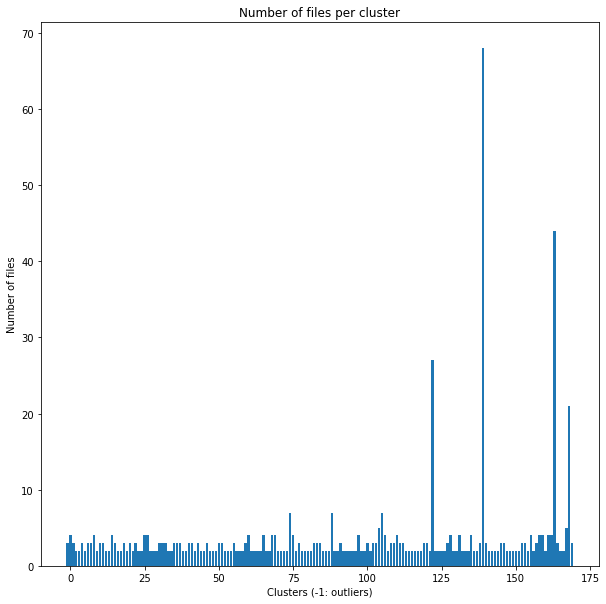

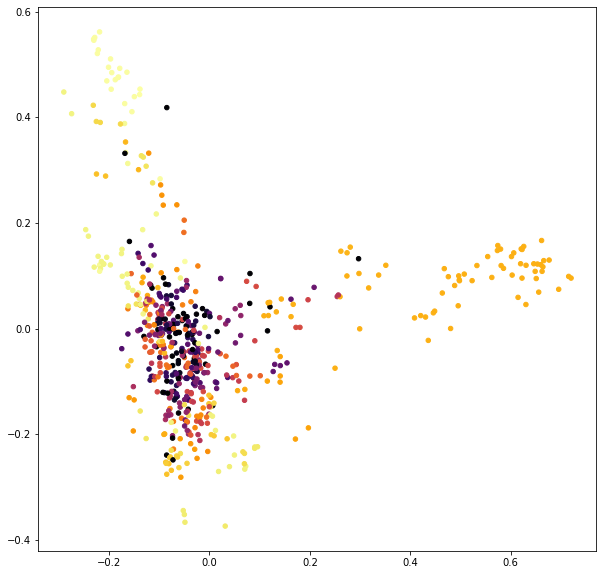

In [46]:
hscan = hdbscan.HDBSCAN( metric='precomputed', min_cluster_size=2, min_samples=1,
                        cluster_selection_epsilon=0.5, p=None)
hscan.fit(cosdis)
print(hscan.labels_)
print(f"silhouette score = {silhouette_score(X, hscan.labels_)}")
dblab = pd.DataFrame({'cluster' : hscan.labels_})

plt.figure(figsize=(10,10))
plt.bar(dblab.cluster.unique(),dblab.cluster.value_counts())
plt.xlabel('Clusters (-1: outliers)')
plt.ylabel('Number of files')
plt.title('Number of files per cluster')
plt.show()

pca = PCA(n_components=2) # call PCA -> reduce to 2 dimensions
dense = X.todense() # convert sparse to dense matrix
X_reduced = pca.fit_transform(dense) # reduce dimensionality vector matrix

lst = hscan.labels_.tolist()
plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:,0],X_reduced[:,1], s=20, c=lst, cmap='inferno')
plt.show()

In [47]:
a = np.where(hscan.labels_==0)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[37, 454]
['1ff78bb0d3ae162bf65b3af5fa48e842.pdf', '578adbcfbe04c7b141198d9d45ad786a.pdf'] 

[[1.        0.9730484]
 [0.9730484 1.       ]]


In [48]:
a = np.where(hscan.labels_==1)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[47, 373, 427]
['b50f772b379eeaa8ff168f1ae136a3a2.pdf', '0c85b18119ae13a90cb8cf8800d6cda9.pdf', '50050d0252781bcd01229f2f0c3b34a1.pdf'] 

[[1.         0.91242191 0.88165133]
 [0.91242191 1.         0.97631865]
 [0.88165133 0.97631865 1.        ]]


In [49]:
a = np.where(hscan.labels_==3)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[236, 535]
['626497877d2c7dd382e65384a5078153.pdf', '8b20205d3caf310540a645ca4c1e1fcb.pdf'] 

[[1.         0.97939756]
 [0.97939756 1.        ]]


In [50]:
a = np.where(hscan.labels_==52)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[179, 252, 376, 433]
['2489f8716395e2fb0197e9598cacb47b.pdf', 'cd12f391a28e33c8b923389f49cb2994.pdf', 'b50ea34b3cb9929927cdcb0bc5b04d9a.pdf', '3723157299fc5b8ecf75c5a1c83de2ab.pdf'] 

[[1.         0.66971278 0.51398602 0.47732499]
 [0.66971278 1.         0.86654761 0.61714246]
 [0.51398602 0.86654761 1.         0.70074318]
 [0.47732499 0.61714246 0.70074318 1.        ]]


In [57]:
a = np.where(hscan.labels_==133)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[246, 273, 397]
['d78a35573e7bbf9bb18d8be2709f5da1.pdf', '7c87c12305f2fbfeb9543007f6487b5d.pdf', '826c19ba8ec8e19b726eb91eabb791c3.pdf'] 

[[1.         0.45692846 0.89755307]
 [0.45692846 1.         0.27504523]
 [0.89755307 0.27504523 1.        ]]


In [60]:
a = np.where(hscan.labels_==162)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[17, 89, 142, 240, 436, 458, 466]
['6c6254ab7171b47e41cce228253b9063.pdf', '48e5f8833d0774e416739c5fb410eb8c.pdf', '2306814cbd6ea9b2128734227d00da14.pdf', 'b982ae3f37477f504c6015dfa57d1544.pdf', '4acad068f8c1c91984b19181856ed72a.pdf', '13032cbf13065a52522ead70395c2f9f.pdf', '52986313d803a180bf1a8daf93b82a18.pdf'] 

[[1.         0.26498034 0.44526448 0.46212364 0.24918061 0.47945933
  0.85768108]
 [0.26498034 1.         0.57430299 0.45387621 0.93918802 0.48704194
  0.25759318]
 [0.44526448 0.57430299 1.         0.95300908 0.5428686  0.95968946
  0.50187928]
 [0.46212364 0.45387621 0.95300908 1.         0.43294661 0.94958212
  0.54641752]
 [0.24918061 0.93918802 0.5428686  0.43294661 1.         0.45737434
  0.25082579]
 [0.47945933 0.48704194 0.95968946 0.94958212 0.45737434 1.
  0.5296946 ]
 [0.85768108 0.25759318 0.50187928 0.54641752 0.25082579 0.5296946
  1.        ]]


In [63]:
a = np.where(hscan.labels_==120)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[101, 333]
['ef57f4bbc20ad295eaa84b201ca5e6c1.pdf', '27831456ea4744902f2887ba25785856.pdf'] 

[[1.         0.94957931]
 [0.94957931 1.        ]]


 ### Agglomerative Clustering

[  7  57   9   4   2  35  25   2   7  40  69  14 108   2  16  54   7  17
 204  80  50  62  22 170  10 219  28 138 154   7  98  52  84  58  63  93
  68 192  33  11  55  21 119  66 211 215  79  85 200  60   7 131 142  57
  67  91 208 154 210 107   7  81   9 138 181   7 219  34  70   9  26   9
 161   7 206 202 193  31 141  12  31 159  76  14  31 187 193  87 153 111
  28  30 122  96 115   7  45  59 155  70  61  15  80   0   7   7  31   7
 167 172  73  72 136  29  57  15  25  23 217   5  26   7 136 124   7 113
 144  57 122  42 132  51   2  20 109  94  34  88 107  77  37 150  17   7
  57  28 182  43 207  86  57 218 176 146 220  13   9 213 178 177  46  44
 149 100  19  38  45 106   2  12  39   2 183   2  48  75 114  47  49  32
  74  27 216   7  38  39  65  90  20   7  16   4 100 216 194   6 133  78
 157 120 184  22   9 163 104 205 116   2  18 139  56   6   2 161  89  33
   7  62 103 190  92 173 161   3 100   7  57  18  29   1  71 145  60 208
 110  83 195 189 143 164  17 181 137  80 168 152  3

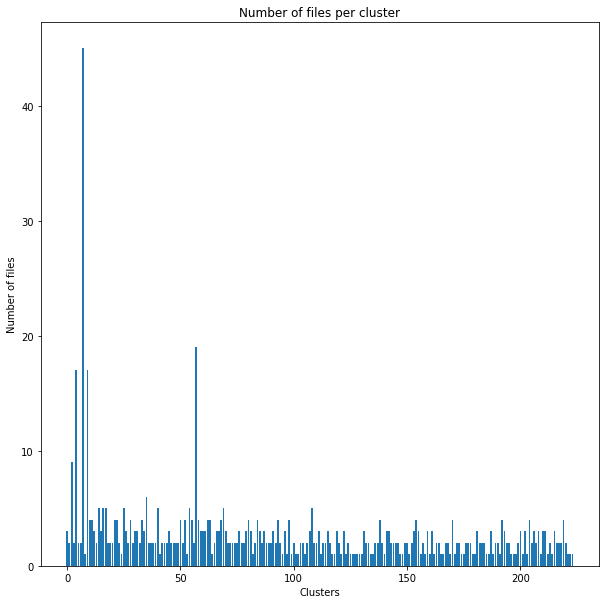

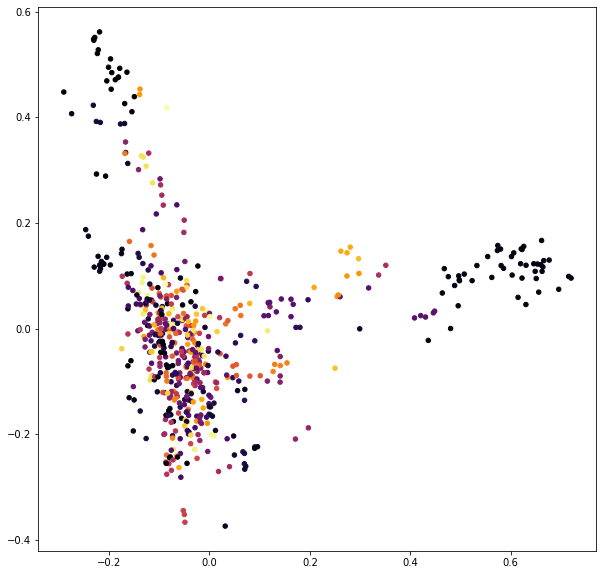

In [66]:
agglom = AgglomerativeClustering(
    n_clusters=None, affinity='cosine', memory=None, connectivity=None, compute_full_tree='auto', 
    linkage='average', distance_threshold=0.6 # 0.4
    )
Xdense = X.todense()
agglom.fit_predict(Xdense)
print(agglom.labels_)
print(f"silhouette score = {silhouette_score(X, agglom.labels_)}")
agglolab = pd.DataFrame({'cluster' : agglom.labels_})

plt.figure(figsize=(10,10))
plt.bar(agglolab.cluster.unique(),agglolab.cluster.value_counts())
plt.xlabel('Clusters')
plt.ylabel('Number of files')
plt.title('Number of files per cluster')
plt.show()

pca = PCA(n_components=2) # call PCA -> reduce to 2 dimensions
dense = X.todense() # convert sparse to dense matrix
X_reduced = pca.fit_transform(dense) # reduce dimensionality vector matrix

lst = agglom.labels_.tolist()
plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:,0],X_reduced[:,1], s=20, c=lst, cmap='inferno')
plt.show()

In [67]:
a = np.where(agglom.labels_==1)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[229, 379, 563, 596]
['18554db6f99e8c713c1445c9a99f6bd0.pdf', 'e4ccbd8e96f8ac6cbd67f038c77d16e2.pdf', '9272950b4eb08635fb8685e4b727087a.pdf', '638dd63d9e76ef40738816bf1bc6577c.pdf'] 

[[1.         0.91045429 0.88957556 0.47042589]
 [0.91045429 1.         0.95879111 0.38993933]
 [0.88957556 0.95879111 1.         0.3604688 ]
 [0.47042589 0.38993933 0.3604688  1.        ]]


In [68]:
a = np.where(agglom.labels_==70)
a = a[0].tolist()
print(a)
def file(number):
    return kl.loc[number,'filename']
print(list(map(file,a)),"\n")
r = np.array(a)
c = np.array(a)
print(cosim[np.ix_(r, c)])

[68, 99, 338, 459]
['e811c462e7edb8b5cd988fda5e767c00.pdf', 'd1fdd4ba966ceb5984547e0999eb0490.pdf', 'b300ba33628043463fe2f6d5d95e3994.pdf', '12a86e53c77cdefeeaadb93abf506621.pdf'] 

[[1.         0.82016698 0.91066661 0.73105847]
 [0.82016698 1.         0.81998606 0.74025762]
 [0.91066661 0.81998606 1.         0.7542477 ]
 [0.73105847 0.74025762 0.7542477  1.        ]]


### Spectral Clustering

In [ ]:
delta = cosdis.max()-cosdis.min()/2

In [ ]:
af = np.exp(- cosdis ** 2 / (2. * delta ** 2))

In [ ]:
sc = SpectralClustering(affinity='precomputed', n_init=100) # default is 8 clusters

In [ ]:
sc.fit_predict(af) 

In [ ]:
print(sc.labels_)
print(f"silhouette score = {silhouette_score(cosdis, sc.labels_)}")
sclab = pd.DataFrame({'cluster' : sc.labels_})

In [ ]:

plt.figure(figsize=(10,10))
plt.bar(sclab.cluster.unique(),sclab.cluster.value_counts())
plt.xlabel('Clusters')
plt.ylabel('Number of files')
plt.title('Number of files per cluster')
plt.show()

pca = PCA(n_components=2) # call PCA -> reduce to 2 dimensions
dense = X.todense() # convert sparse to dense matrix
X_reduced = pca.fit_transform(dense) # reduce dimensionality vector matrix

lst = sc.labels_.tolist()
plt.figure(figsize=(10,10))
plt.scatter(X_reduced[:,0],X_reduced[:,1], s=20, c=lst, cmap='inferno')
plt.show()